In [1]:
import warnings
warnings.filterwarnings('ignore')

import scanpy as sc
import pandas as pd
import os
import anndata as ad
import scipy as sp

In [2]:
adata = sc.read_h5ad('../../results/cell_2022/scrna.h5ad')
adata

AnnData object with n_obs × n_vars = 147836 × 57874
    obs: 'Well_ID', 'well_coordinates', 'Amp_batch_ID', 'Cell_barcode', 'Seq_batch_ID', 'Pool_barcode', 'Pool_barcode_i5', 'Number_of_cells', 'annotation', 'sample_name', 'selection_marker', 'source_name', 'tissue', 'patient_id', 'organism', 'batch'

In [3]:
df_patient = pd.read_excel('../../data/GSE195452/mmc1.xlsx', header=1)
df_patient.columns = df_patient.iloc[0]
df_patient = df_patient[1:]

df_patient = df_patient[['PID', 'Disease']]
df_patient.columns = ['patient_id', 'condition']
df_patient['condition'] = df_patient['condition'].astype(str)

df_patient.head()

,patient_id,condition
1,pt01001,SSC
2,pt01002,SSC
3,pt01003,SSC
4,pt01004,SSC
5,pt01005,SSC


In [4]:
adata.obs = pd.merge(adata.obs, df_patient, on='patient_id', how='left')

# https://github.com/scverse/scanpy/issues/747
adata.obs.index = adata.obs.index.astype(str)

In [5]:
adata.obs['patient_id'].value_counts()

pt01033       4327
Ctrl003       3804
pt01020       2723
Ctrl014       2655
pt01050       2565
              ... 
pt01008         66
Ctrl040         66
pt01053         50
GVHD_pt007      12
Ctrl054         10
Name: patient_id, Length: 173, dtype: int64

In [6]:
adata.obs['tissue'].value_counts()

Skin     105208
Blood     40137
Lung       1406
skin       1085
Name: tissue, dtype: int64

In [7]:
adata.obs['selection_marker'].value_counts()

CD90+              73826
CD45+              62073
Peri_Vas            4206
CD90+LGR5+DPP4+     2438
CD90-CD45-          1993
CD45+CD90+          1305
B2M+                 678
CD14+CD16+           552
CD90+LGR5+           422
NONB/T               288
CD31+                 55
Name: selection_marker, dtype: int64

In [8]:
df = adata.obs

In [9]:
df.groupby([df.selection_marker, df.annotation]).sum().unstack().fillna(0).astype(int)

Number_of_cells                                           \
annotation                     B B_CXCR4    DC DC_CCL22 DC_CXCL10 DC_XCR1   
selection_marker                                                            
B2M+                           0       0     0        0         0       0   
CD14+CD16+                     1       0     7        0         1       0   
CD31+                          0       0     0        0         0       0   
CD45+                       3688     176  3941      186       156     475   
CD45+CD90+                     3       0   115       10         2      11   
CD90+                          2       3   197       10         9      17   
CD90+LGR5+                     0       0     0        0         0       0   
CD90+LGR5+DPP4+                0       0     0        0         0       0   
CD90-CD45-                     0       0     0        0         0       0   
NONB/T                         0       0    21        0         0       0   
Peri_Vas                       0       0     0        0         0       0   

                                                              ...            \
annotation       Fibro_ACTA2 Fibro_Bad Fibro_COCH Fibro_COMP  ... Treg   UN   
selection_marker                                              ...             
B2M+                       0         0          0          9  ...    0    0   
CD14+CD16+                 0         0          0          0  ...    0    0   
CD31+                      0         0          0          0  ...    0    0   
CD45+                     10        12         76         46  ...  486  304   
CD45+CD90+                30         2         18         24  ...    0    6   
CD90+                    872       465       2055       2428  ...    0   65   
CD90+LGR5+                 0         0          0          6  ...    0    0   
CD90+LGR5+DPP4+            1         4         18        131  ...    0    0   
CD90-CD45-                 0         1          0          4  ...    0    0   
NONB/T                     0         0          0          0  ...    0    0   
Peri_Vas                   1         2          0          7  ...    0    0   

                                                                    \
annotation       Vascular_ACKR1 Vascular_RBP7  pDC pDC_CXCR4    sT   
selection_marker                                                     
B2M+                         56             4    0         0     0   
CD14+CD16+                    0             0    0         0     0   
CD31+                        45             0    0         0     0   
CD45+                        27            24  159       102  6371   
CD45+CD90+                   17            25    3         4    90   
CD90+                      2079          1869    1         2   135   
CD90+LGR5+                   11             5    0         0     0   
CD90+LGR5+DPP4+              32            65    0         0     0   
CD90-CD45-                  126            20    0         0     0   
NONB/T                        0             0    1         0     1   
Peri_Vas                   1591           312    0         0     0   

                                                
annotation       sT_Effector sTreg sTreg_CXCR4  
selection_marker                                
B2M+                       0     0           0  
CD14+CD16+                 0     0           0  
CD31+                      0     0           0  
CD45+                    824   414         248  
CD45+CD90+                11     5           3  
CD90+                     13     5          13  
CD90+LGR5+                 0     0           0  
CD90+LGR5+DPP4+            0     0           0  
CD90-CD45-                 0     0           0  
NONB/T                     0     0           0  
Peri_Vas                   0     0           0  

[11 rows x 52 columns]

In [10]:
# filter cells
adata = adata[adata.obs['condition'].isin(['SSC', 'Control']), ]
adata = adata[adata.obs['tissue'].isin(['Skin', 'skin']), ]
adata = adata[adata.obs['selection_marker'].isin(['CD45+', 'CD90+']), ]
adata = adata[~adata.obs['annotation'].isin(['UN', 'GBP1', 'NRXN1']), ]

In [11]:
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_cells(adata, min_counts=500)

In [12]:
adata

AnnData object with n_obs × n_vars = 83279 × 57874
    obs: 'Well_ID', 'well_coordinates', 'Amp_batch_ID', 'Cell_barcode', 'Seq_batch_ID', 'Pool_barcode', 'Pool_barcode_i5', 'Number_of_cells', 'annotation', 'sample_name', 'selection_marker', 'source_name', 'tissue', 'patient_id', 'organism', 'batch', 'condition', 'n_genes', 'n_counts'

In [13]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

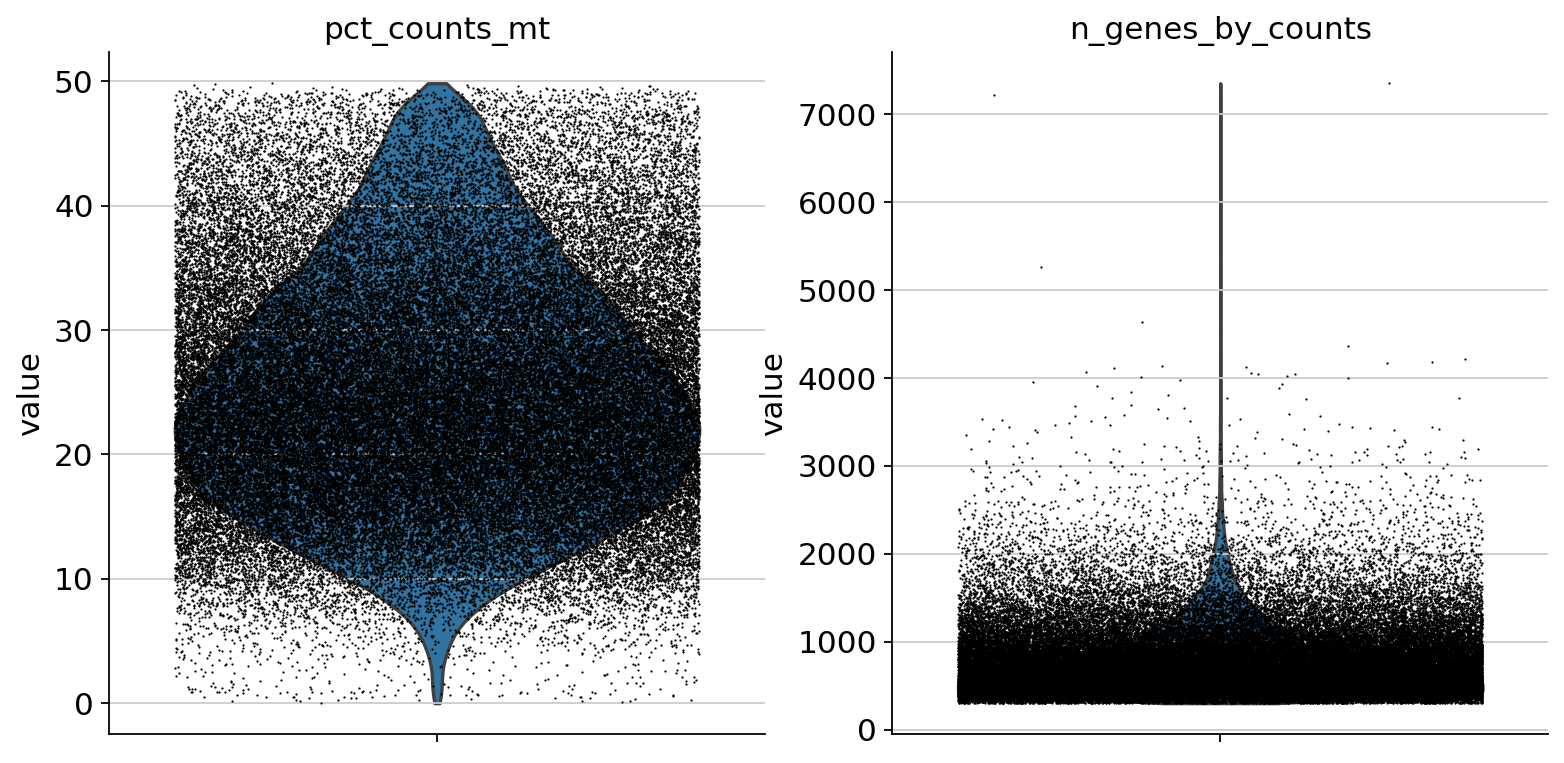

In [14]:
sc.set_figure_params(figsize=(12, 6))

sc.pl.violin(adata, ['pct_counts_mt', 'n_genes_by_counts'],
             jitter=0.4, multi_panel=True)

In [15]:
adata = adata[adata.obs.n_genes_by_counts < 5000, :]
adata = adata[adata.obs.pct_counts_mt < 30, :]

In [16]:
sc.pp.filter_genes(adata, min_cells=1)

In [17]:
adata

AnnData object with n_obs × n_vars = 58351 × 45475
    obs: 'Well_ID', 'well_coordinates', 'Amp_batch_ID', 'Cell_barcode', 'Seq_batch_ID', 'Pool_barcode', 'Pool_barcode_i5', 'Number_of_cells', 'annotation', 'sample_name', 'selection_marker', 'source_name', 'tissue', 'patient_id', 'organism', 'batch', 'condition', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [18]:
adata.layers['counts'] = adata.X.copy()

In [19]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.umap(adata)

2023-10-19 22:55:47.894127: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-19 22:55:48.704318: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


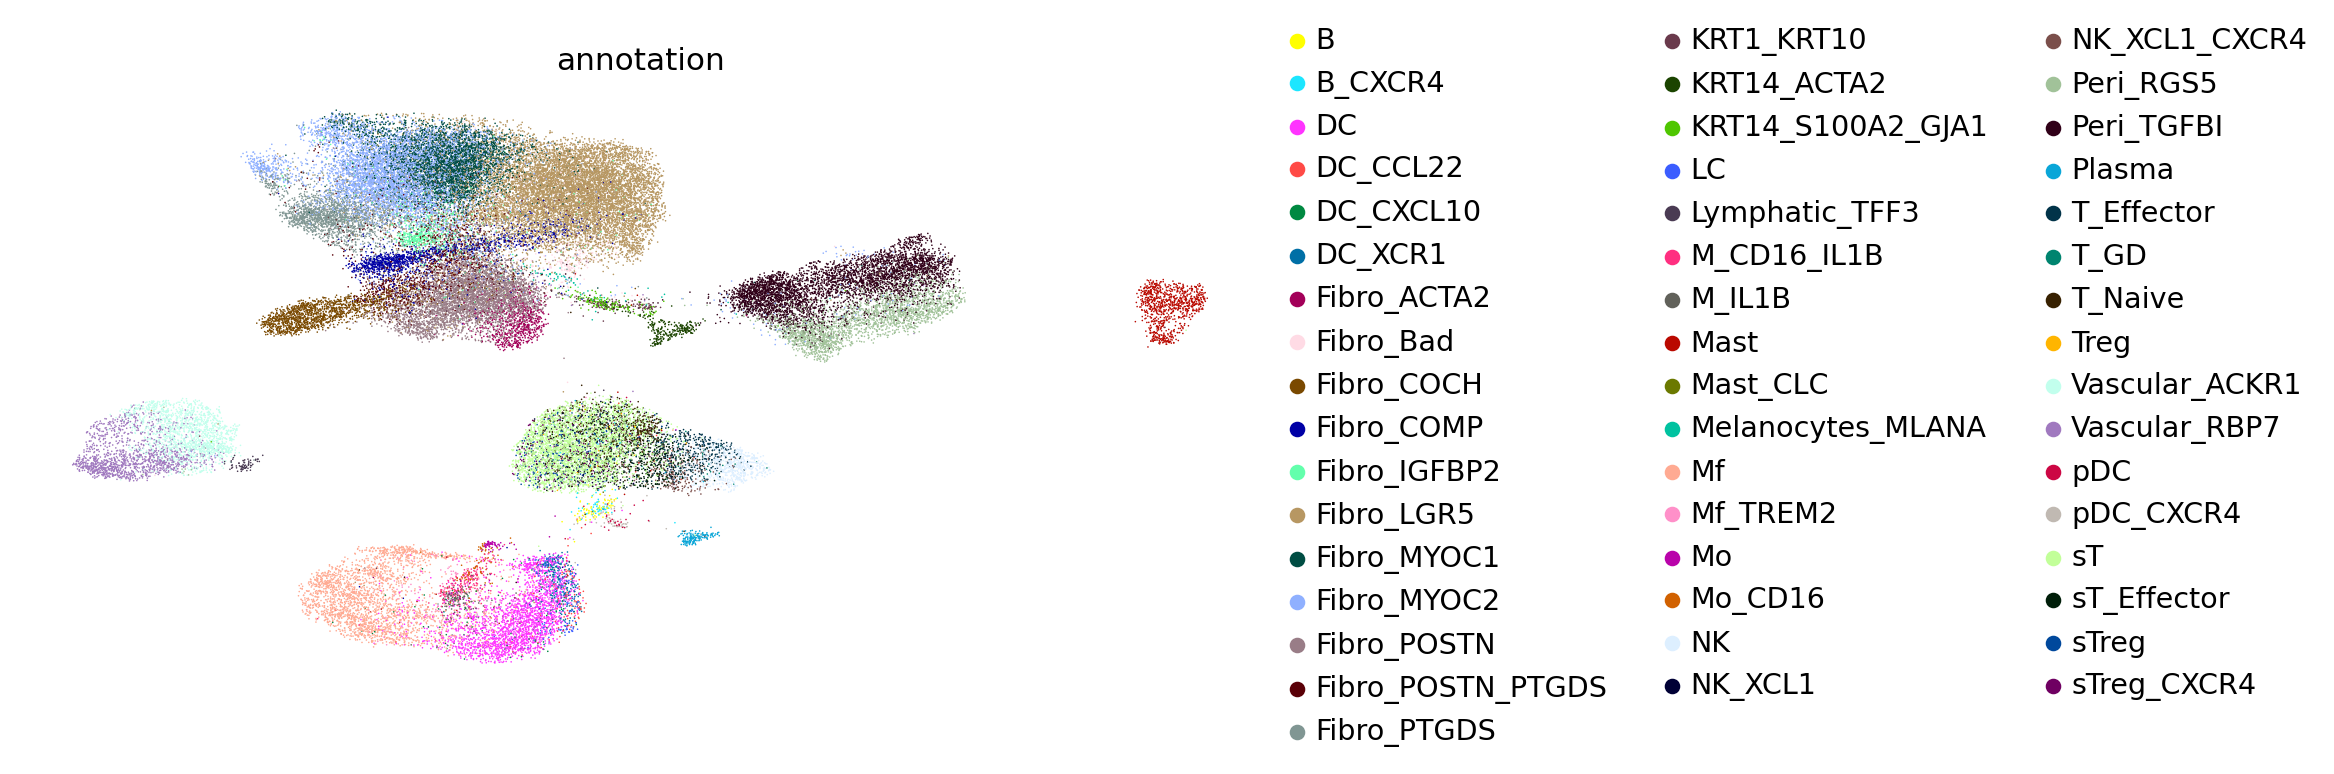

In [20]:
sc.set_figure_params(figsize=(10, 5))

sc.pl.umap(adata, color=['annotation'], frameon=False)

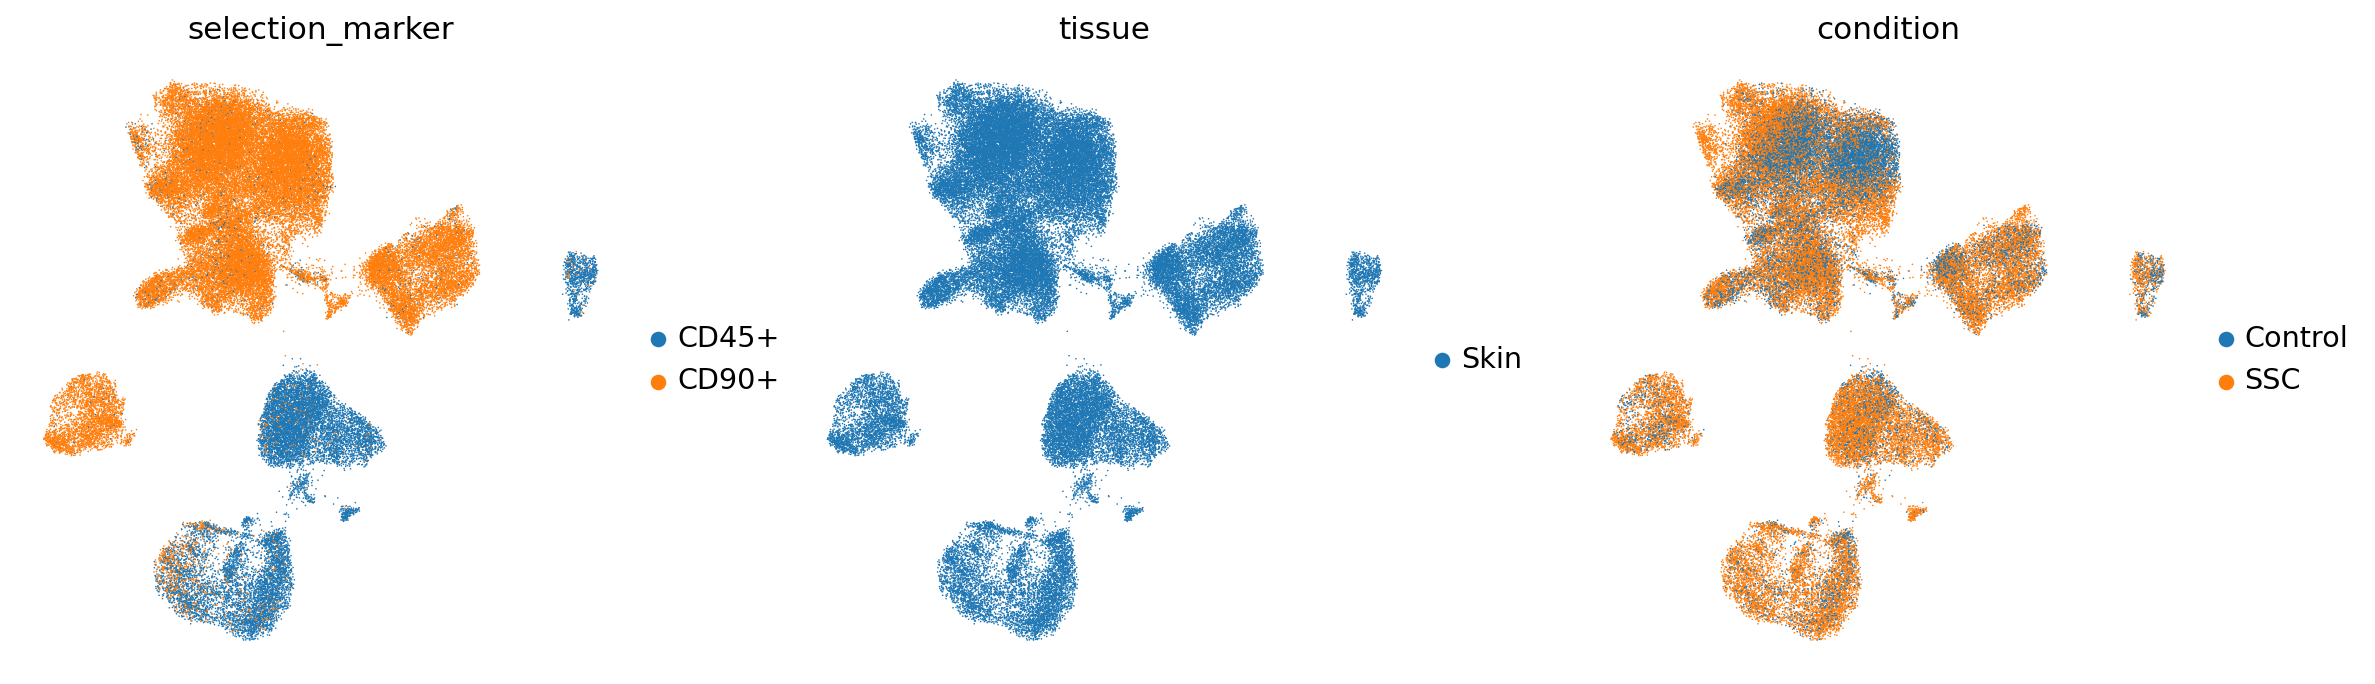

In [21]:
sc.set_figure_params(figsize=(5, 5))

sc.pl.umap(adata, color=['selection_marker', 'tissue', 'condition'], frameon=False)

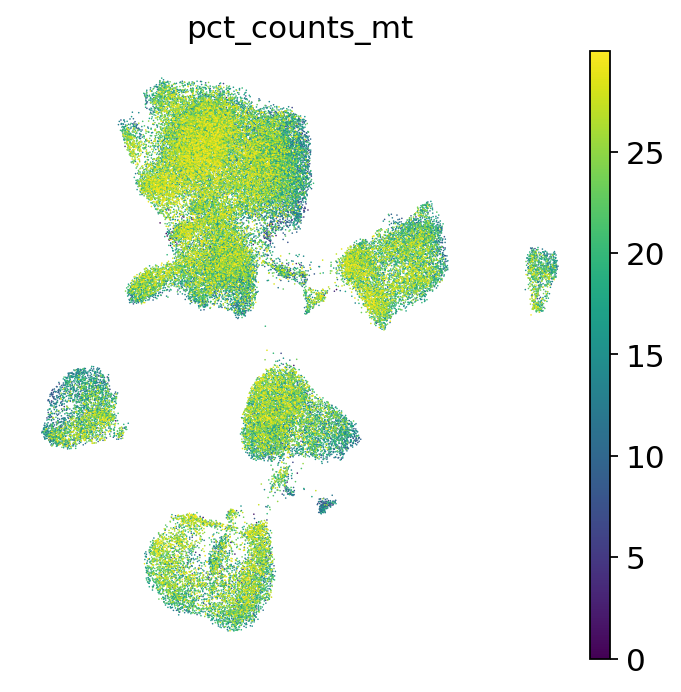

In [22]:
sc.pl.umap(adata, color=['pct_counts_mt'], frameon=False)

In [23]:
adata.write_h5ad('../../results/cell_2022/scrna.skin.h5ad')